In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci

# CDF Creation

The code below is designed to return a full CDF as an array for any pdf passed as an array. It leverages the idea that the PDF is passed as an array and each value of the array is separated by some distance on the x-axis to create a Riemann sum. To make it work you must pass a PDF in the form of an array and an array of x-values (called x_space) that is the same length as the PDF array. By "x-values" I'm simply referring to any parameter you're plotting on the x axis of a distribution. For our cases these are the parameters of binary systems such as mass, radius, period, and eccentricity. You want it such that the values of x_space correspond to the values of the PDF array such that the value PDF[0] corresponds to the x-value indexed at 0, x_space[0] and so on.

![](https://cocalc.com/blobs/paste-0.025670194811481473?uuid=6215d751-de9c-47a2-92bb-cc98689480e8)

Imagine the above figure is our PDF. The solid line represents the analytical form of the PDF that is a function while the bars represent the PDF array we are passing where the height is the value of the array at some index. The width of the bar ($\Delta x$) corresponds to the separation of the values of x_space. For example, if we have a hypothecal PDF that takes values on the x axis ranging from 0 to 1 and we split that into ten bins equally spaced then we will have 10 values of the pdf that are each spaced by 0.1 on the x axis. Because a PDF is normalized if we sum up the areas of these bars they should add up to 1.

We start from the minimum x-value of our distribtion and start integrating towards the maximum x-value. To do this, initialize some variable, $\texttt{sum}$, to be zero. We will then add the areas of the rectangles iteratively to $\texttt{sum}$. Recall the area of the rectangle is equal to the height of the rectangle which is the value of the pdf times the width which is the difference of array values of x_space. This process is just a Riemann sum, and for sufficiently small bins (equivalent to saying we have a large enough number of values of the PDF and x_space arrays) this should approximate the integral very well.

Now we recall the definition of a CDF at some value $x_i$ is value of the integral starting at the minimum x-value, $x_0$ to the value $x_i$:

$\text{CDF}(x_i) = \int_{x_0}^{x_i} \text{PDF}$

So this means that as we iterate along the areas of the rectangles and add the values to $\texttt{sum}$ we are tabulating the values of the CDF of all the values of x. This means when we add the area of the first rectangle (the one between $x_0$ and $x_1$ in the figure above) to $\texttt{sum}$ we've calculated the CDF at $x_1$ (the value of the CDF for $x_0$ must be zero). When we add the area of the second rectangle to that running tally of $\texttt{sum}$ then we get the sum of the areas of both the first and second rectangle, meaning we've integrated from $x_0$ to $x_2$, equivalent to the CDF at $x_2$. So long as we can store these values as we integrate from $x_0$ to the max value $x_{\text{max}}$ we should have our list of CDF values when we're done that's the same length as the PDF and x_space arrays.


In [3]:
#CDF Generator, should work for any normalized distribution function

#The function will return the full CDF from the minimum allowed
#value in the distribution to the maximum

#x defines the upper bounds of the integration from zero

#Until the upper bound x is reached

#Input distribution, dist, must be inserted as 1D array

#x_space is the 1D array of elligible values in the distribution

#x_space should be same shape as dist!!

def CDF_generator(pdf, x_space):

    #Initialize the value of the CDF
    #This will keep climbing towards 1 as we iterate
    #And sum up each little bit of the pdf
    CDF = 0

    #Initialize the list that will store the values of the CDF at each x value
    #As we move along the distribution we'll keep track of the CDF values and store them
    #Here

    #It will end up being the same length as the x_space argument so we'll know each value
    #of the cdf corresponds to a certain value in the distribution

    #Okay so some rapidly rising CDFs like the IMF have this fun feature where they rise so
    #fast that their first indexed value is pretty large (like 0.038), this means that when inverting
    #the CDF there's a 3.8% chance the random number generator picks a value for which the invertor can't
    #find an appropriate value on the x-axis (there's no CDF value for the algorithm to find if the random
    #number generator picks 0.02) so we get an infinite loop. To fix this we'll assert that the first value of
    #the CDF must be exactly zero so we do have values of the CDF rangning from 0 to 1
    
    #Keep in mind that later on we may get the reverse problem! We to make sure that the last indexed
    #value of the CDF is 1 or really close to one
    
    CDF_list = [0]

    i = 0

    #We'll keep iterating until we integrate over the full PDF
    #the length must be the length of the pdf minus one because we already filled
    #the first index with zero
    while i < (len(pdf) - 1):
        
        #Add the area of one bin of the pdf to the CDF total
        
        #I chose to make the width x_space[1] - x_space[0]
        #as to be invariant to what binning I'm using
        CDF = CDF + (pdf[i]* (x_space[1] - x_space[0]))
        
        #Append that CDF value to the array

        CDF_list.append(CDF)

        i = i + 1
        
    #make sure the last index is equal to 1 so we don't generate a random number
    #outside the range of the y axis of the CDF
    
    CDF_list[len(x_space) - 1] = 1

    return CDF_list

## CDF Inversion

Now I'm going to show how to make a generalized CDF inverter to turn any y value of any CDF into a value on the x-axis. It's a bit trickier than first expected. The first step is to generate a CDF from a PDF using the previously defined function. The first catch in this process is to recall that we want to find the value along the x axis that when plugged into the CDF returns a desired y value (we just call that input y in our code). It turns out this is tough to do if we leave our CDF as an array because it's tricky to correlate a specific value on the x-axis with an index in the array. The best thing to do is to turn the CDF into something callable where we can pass in any possible x value and get out the y value of the CDF there.

Interpolating the CDF is the best way to accomplish this. If you don't know what interpolation is you should add it to your tool belt for sure. scipy.interpolate.interp1d will take a list of x values and list of y values of equal length (which is the CDF in this case) and connect the values so every possible x value has a y value. It does this by just drawing a straight line from one point to the other so if your data has curves you need to make sure you are providing a sufficient number of points for the interpolation to be an accurate approximation, although this is rarely an issue in practice.

![](https://cocalc.com/blobs/paste-0.9261892991321625?uuid=0731a423-e5a3-4720-b0fe-3cb51461e5f4)

We don't need anything fancy, linear interpolation should work just fine.

With this interpolated callable CDF we can run a binary search. If you tried the guessing challenge from the first week of class you may already be familiar with the process. Essentially we start in the middle of the x-sample range and check to see in the CDF there is higher or lower than the y value we want. If it's higher then we know we need to search the first half of the range so we redo the search there looking halfway between the lowest possible value and the value we just guessed. If the guess was too low we look in the second half of the range. Repeat the process until the value of the CDF at some x coordinate is within some tolerance from the desired y value. When that's done we want to return the x value.
![](https://cocalc.com/blobs/paste-0.7456299452885147?uuid=b38c227d-ff66-40ea-827e-9ac1ae37d00f)


For the following function we will have it such that we need to pass a desired value on the y axis, an INTERPOLATED CDF, and the list of x vlaues. The first input gives the code a goal to shoot for, the second is the CDF it will trace to try to find the y value, and the x_space is just to initialize the guess of binary search.


In [5]:
#Find x value for some y value
#I'm going to use binomial search because the fucnction monotomically rises

def CDF_invert(y, cdf_interp, x_space):
    
    #max guessing bound, will change during the loop
    #start it at the maximum possible value of the x_values
    maxi = max(x_space)

    #min guessing bound, will change during the loop
    #start at the minimum possible value of the x_values
    mini = min(x_space)

    #initialize the guess for the right value in the middle
    #of the range
    x = 0.5 * (mini + maxi)

    #keep iterating until our CDF value reaches desired value plus or minus a small tolerance value
    while (cdf_interp(x) > y + 0.0001) or (cdf_interp(x) < y - 0.0001):

        #if the CDF here is too big
        if cdf_interp(x) > y:

        #Change the guessing range to be between mini and x
            maxi = x
        
        #Update the value of the guess to be halfway between mini and what
        #we just guessed
            x = 0.5 * (mini + x)

        
        #If the CDF is too small
        if cdf_interp(x) < y:

        #Change the guessing range to be between maxi and x
            mini = x
        
        #Update the value of the guess to be halfway between maxi and what
        #we just guessed
            x = 0.5 * (maxi + x)

    #Tell us what x value caused the loop to break    
    return x

## Generate Random Sample

Now we generate a bunch of random values for our sample using the CDF we've defined earlier. The process will involve generating a number between zero and one and using the CDF inverter to see what x value this corresponds to. It's pretty straightforward and simple, just make a random value of the CDF, plug it into the CDF invertor, log the result, repeat N times.

In [7]:
def sample_generator(N, cdf_interp, x_space):

    #initialize empty list of values for the sample

    sample_list = []

    #start the loop, which will repeat N times

    i = 0

    while i < N:

        #generate random y value of the CDF

        y = np.random.rand()

        #see what x value that represents from the inversion

        sample_value = CDF_invert(y, cdf_interp, x_space)

        #add that value to the list for our random sample

        sample_list.append(sample_value)

        #Move to next iteration
        i = i + 1

    return sample_list

## Period CDF

The period distribution of binaries is given with a log\-normal distribution with mean μ\(logP\) = 5.03 and standard deviation 𝜎 \(logP\) = 2.28, both in days. This means we'd get a normal distribution but only if the x axis is in log scale so we need to be extra careful about doing this. To make this easier to code I'm going to mostly be working in log\(P\) as my key variable and convert it to period when I absolutely have to. For anyone reading I highly suggest getting comfortable working both in log and linear scaled units because both are commonly used in astronomy.



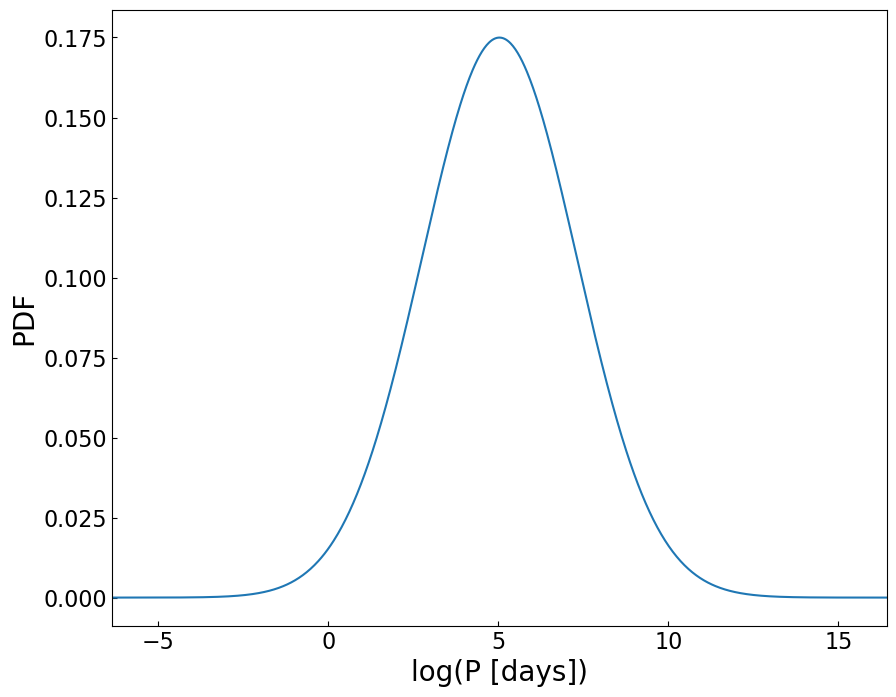

In [9]:
# Generate a normal distribution using scipy's normal pf

#Set the mean, μ, in log space. Time measured in days
log_mu = 5.03

#Set the std deviation, σ, in log space. Time measured in days.
log_sigma = 2.28

#Set range of possible periods within 5σ of the mean
log_P = np.linspace(log_mu - 5 * log_sigma, log_mu + 5 * log_sigma, 1000) #log(period) in days 

#generate pdf object, works as a callable like a function
log_P_pdf = sci.stats.norm.pdf(log_P, log_mu, log_sigma)

plt.figure(figsize = (10, 8))
plt.plot(log_P, log_P_pdf)
plt.xlabel(r'log(P [days])', fontsize = 20)
plt.ylabel(r'PDF', fontsize = 20)
plt.tick_params(direction = 'in', labelsize = 16)
plt.xlim(min(log_P), max(log_P))
plt.show()

Good news is a PDF is already normalized. Recall the PDF stands for Probability Density Function so when we integrate it over all possible values we get 1, the probability any allowed value is chosen. Since the range within 5σ of the mean comprises >> 99.99% of the data we can be sure this will approximately integrate to one. Now we just need to build our CDF and invert it, which we did in class already!



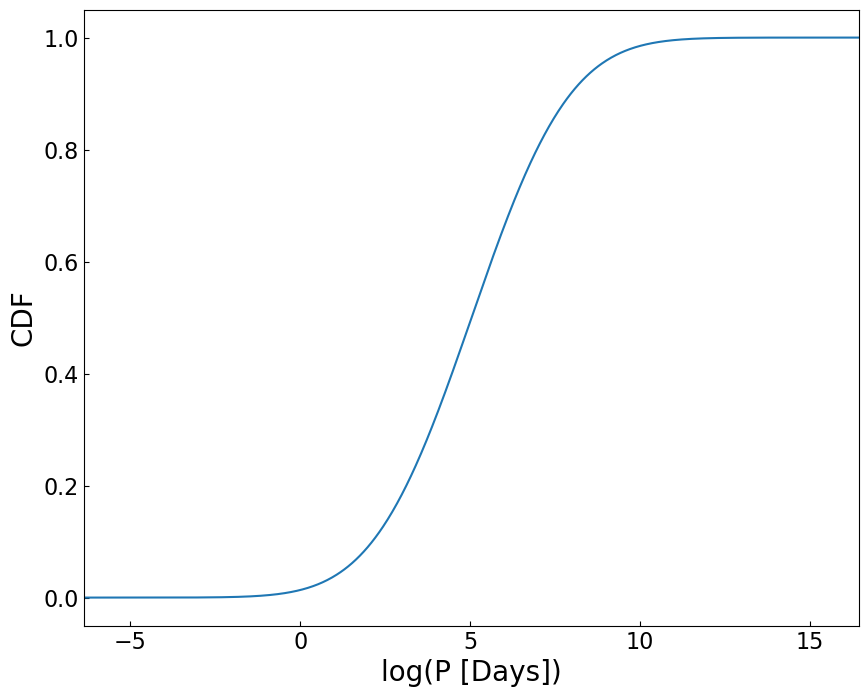

In [11]:
#values of log P allowed
log_P = np.linspace(log_mu - 5 * log_sigma, log_mu + 5 * log_sigma, 1000)

#Generate Period CDF from the PDF

log_P_cdf = CDF_generator(log_P_pdf, log_P)

#Interpolate the CDF to smooth it out and make an x value for
#any possible input x value}

#It's also just great to make the CDF a callable rather than
#an array so for each guess for the x value we can just plug it
#in rather than trying to figure out what index it corresponds to
#in an array

log_P_cdf_interp = sci.interpolate.interp1d(log_P, log_P_cdf)


#PLOT
#Always make sure your plot is big with large text, I'm trying to not lose my sight
#from constant squinting at my blue light death machine.
plt.figure(figsize = (10,8))
plt.plot(log_P, log_P_cdf)
plt.xlabel('log(P [Days])', fontsize = 20)
plt.ylabel('CDF', fontsize = 20)
plt.tick_params(direction = 'in', labelsize = 16)
plt.xlim(min(log_P), max(log_P))
plt.show()

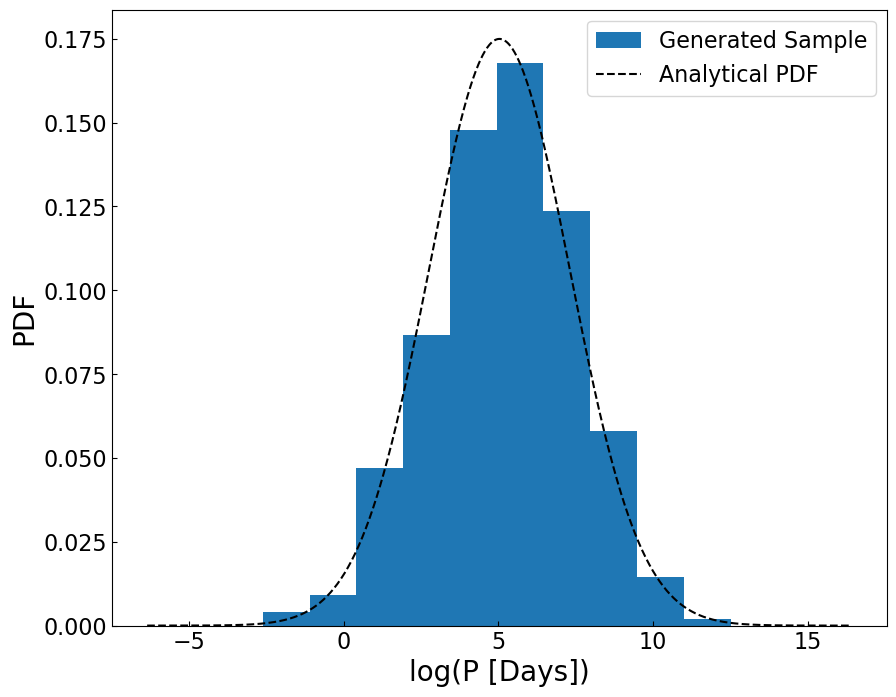

In [12]:
#Plot sample generation

sample_log_P = sample_generator(1000, log_P_cdf_interp, log_P)

plt.figure(figsize = (10, 8))
plt.hist(sample_log_P, density = True, label = 'Generated Sample')
plt.plot(log_P, log_P_pdf, color = 'black', linestyle = '--', label  = 'Analytical PDF')
plt.xlabel('log(P [Days])', fontsize = 20)
plt.ylabel('PDF', fontsize = 20)
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend(fontsize = 16)
plt.show()

## Salpeter IMF

The Salpeter IMF determines the reletaive of occurrence of stellar masses of our sample. The formula is:

$\xi \propto M^{\alpha}$ where for the Salpeter IMF $\alpha = -2.35$

$\xi$ is kind of weird and has units of $\frac{1}{dM}$ where dM is the bin of stellar mass in solar masses. This is because the exact value of $\xi$ depends on the binning on the x-axis. But essentially the way to read an IMF graph is that the y axis tells us the relative occurrence of stars and the x axis is the mass of the stars. So the higher up you are the more common the star is. It's also common to plot these IMF graphs in log space (log(M) vs log($\xi$)) because power laws become nice diagonal lines in a log-log graph.

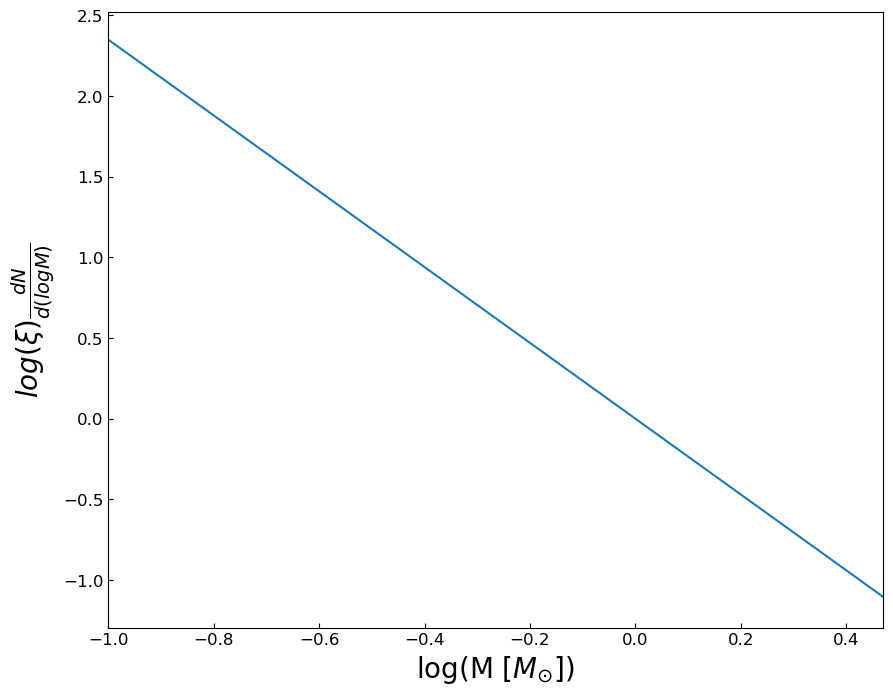

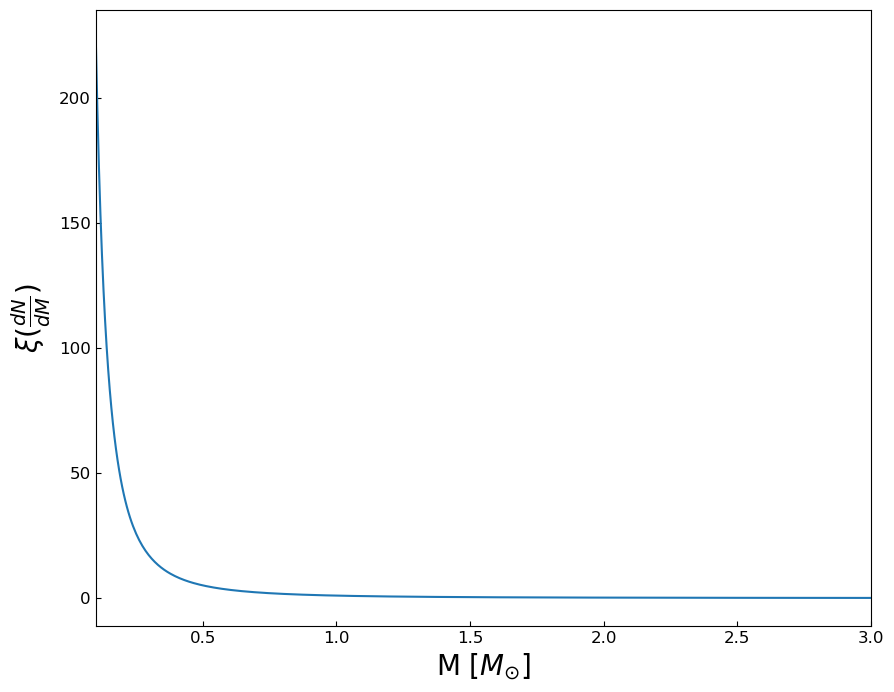

In [14]:

#define Salpeter +55 power law IMF

def Salpeter(M):
    alpha = -2.35
    return M**alpha

#generate sample of masses
M = np.linspace(0.1, 3, 500)

plt.figure(figsize = (10, 8))
plt.plot(np.log10(M), np.log10(Salpeter(M))) 
plt.xlabel(r'log(M [$M_{\odot}]$)', fontsize = 20)
plt.ylabel(r'$log(\xi) \frac{dN}{d(logM)}$', fontsize = 20)
plt.tick_params(direction = 'in', labelsize = 12)
plt.xlim(-1, 0.47)
plt.show()

plt.figure(figsize = (10, 8))
plt.plot(M, Salpeter(M)) 
plt.xlabel(r'M [$M_{\odot}]$', fontsize = 20)
plt.ylabel(r'$\xi (\frac{dN}{dM})$', fontsize = 20)
plt.tick_params(direction = 'in', labelsize = 12)
plt.xlim(0.1, 3)
plt.show()

### Normalize it

In order to normalize this graph we simply need to take the array of values we plugged into the y axis, Salpeter(M), and divide it by the area under the curve. We can take a basic Reimann sum to do this, the sum of the area of rectangles times the widths of each one. This is equal to the sum of the values of the indeces times the width of bins.

$\int_{x_0}^{x_{max}} PDF = PDF[0]* \text{bin\_width} + PDF[1] * \text{bin\_width}...$ 

$\int_{x_0}^{x_{max}} PDF = \sum_{i = 0}^{i = N} PDF[i] * \text{bin\_width} =  \text{bin\_width} * \sum_{i = 0}^{i = N} PDF[i]$

Note: $\sum_{i = 0}^{i = N} PDF[i] = \text{sum(PDF)}$ in Python


The resulting array will be normalized and integrate to unity. This is a good thing to keep in mind if you ever need to normalize a function or distribution and is exactly what python does when you turn on the density keyword argument in plt.hist() or np.histogram().

One important thing to note is that the exact value of the normalized array depends on the number of elements in the array. The more elements in the array the smaller value each one will have once normalized. So two people may have slightly different PDF values of their distributions not because one of them did something wrong but because their x_space samples were different sizes. I doubt it will cause much concern because the CDF should still come out the same but it's good to know in case you need to debug.

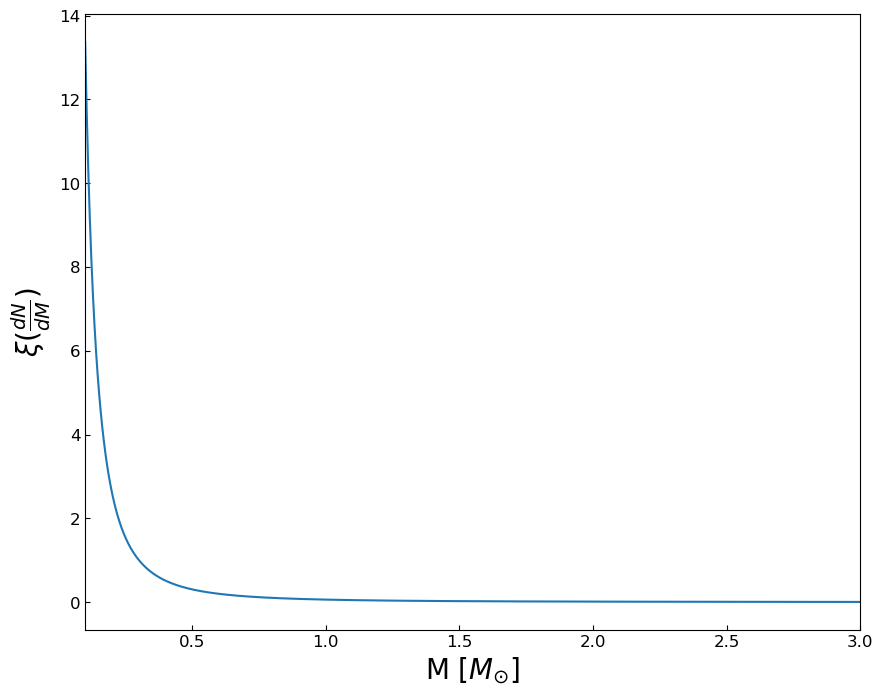

In [16]:
#Generate x_space for masses from 0.1 to 3 solar masses

M = np.linspace(0.1, 3, 1000)


#generate intial array of IMF values
salpeter_pdf = Salpeter(M)

#normalize it by dividing the array by the sum of its elements

salpeter_pdf = salpeter_pdf / ((M[1] - M[0]) * sum(salpeter_pdf))

#plot

plt.figure(figsize = (10, 8))
plt.plot(M, salpeter_pdf) 
plt.xlabel(r'M [$M_{\odot}]$', fontsize = 20)
plt.ylabel(r'$\xi (\frac{dN}{dM})$', fontsize = 20)
plt.tick_params(direction = 'in', labelsize = 12)
plt.xlim(0.1, 3)
plt.show()

This may looks strange because some of the y values are larger than 1 but keep in mind the bin widths are <<1 so the area of each bin is still very small even if it is tall.

### Check the CDF

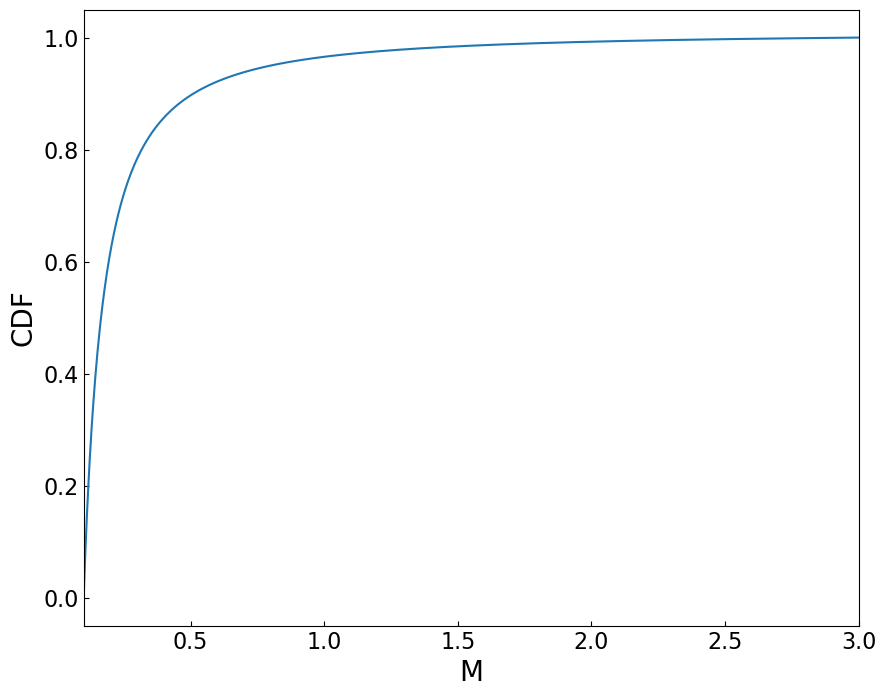

In [18]:
#Generate x_space for masses from 0.1 to 3 solar masses

M = np.linspace(0.1, 3, 1000) #in solar masses

M_bin_width = (M[1] - M[0]) #width of bins of solar mass, equally spaced


#generate intial array of IMF values
salpeter_pdf = Salpeter(M) 


#normalize it by dividing the array by the sum of its elements
salpeter_pdf = salpeter_pdf / (M_bin_width * sum(salpeter_pdf))

#generate the CDF
Salpeter_cdf = CDF_generator(salpeter_pdf, M)

#PLOT
#Always make sure your plot is big with large text, I'm trying to not lose my sight
#from constant squinting at my blue light death machine.
plt.figure(figsize = (10,8))
plt.plot(M, Salpeter_cdf)
plt.xlabel('M', fontsize = 20)
plt.ylabel('CDF', fontsize = 20)
plt.tick_params(direction = 'in', labelsize = 16)
plt.xlim(0.1, 3)
plt.show()

### Generate our random sample of stellar masses

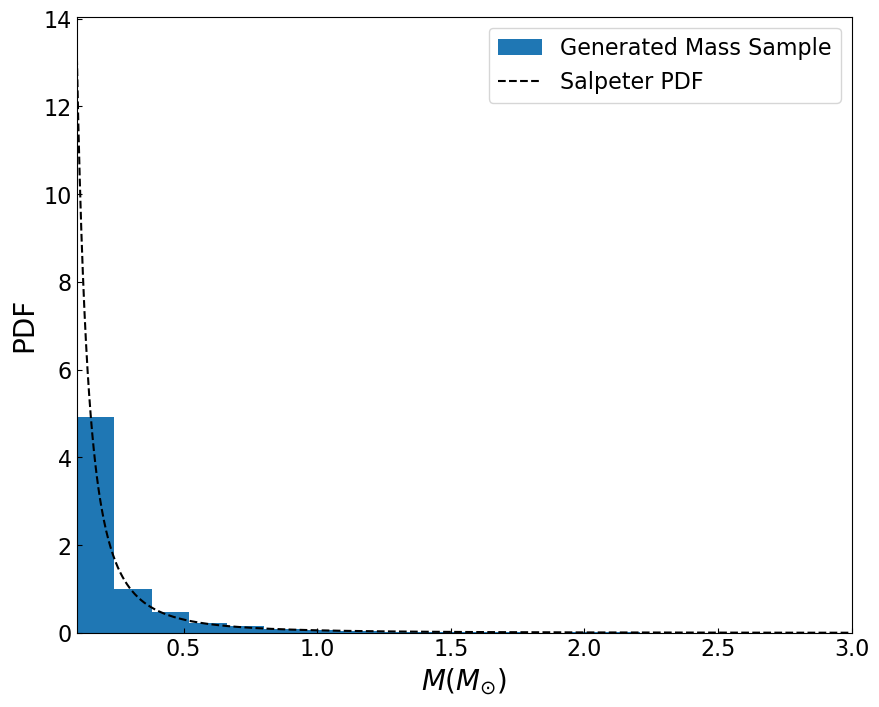

In [20]:
#Generate x_space for masses from 0.1 to 3 solar masses

M = np.linspace(0.1, 3, 1000) #in solar masses

M_bin_width = (M[1] - M[0]) #width of bins of solar mass, equally spaced


#generate intial array of IMF values
salpeter_pdf = Salpeter(M)


#normalize it by dividing the array by the sum of its elements
salpeter_pdf = salpeter_pdf / (sum(salpeter_pdf) * M_bin_width) #This one is normalized


#Generate the CDF
Salpeter_cdf = CDF_generator(salpeter_pdf, M)


#Interpolate it
Salpeter_cdf_interp = sci.interpolate.interp1d(M, Salpeter_cdf)


#Make the sample using the sample generator
sample_M = sample_generator(1000, Salpeter_cdf_interp, M)

#plot the distribution

plt.figure(figsize = (10, 8))
plt.hist(sample_M, density = True, label = 'Generated Mass Sample', bins = 20)
plt.plot(M, salpeter_pdf, color = 'black', linestyle = '--', label  = 'Salpeter PDF')
plt.xlabel(r'$M (M_{\odot})$', fontsize = 20)
plt.ylabel('PDF', fontsize = 20)
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend(fontsize = 16)
plt.xlim(0.1, 3)
plt.show()

### Generating Ω



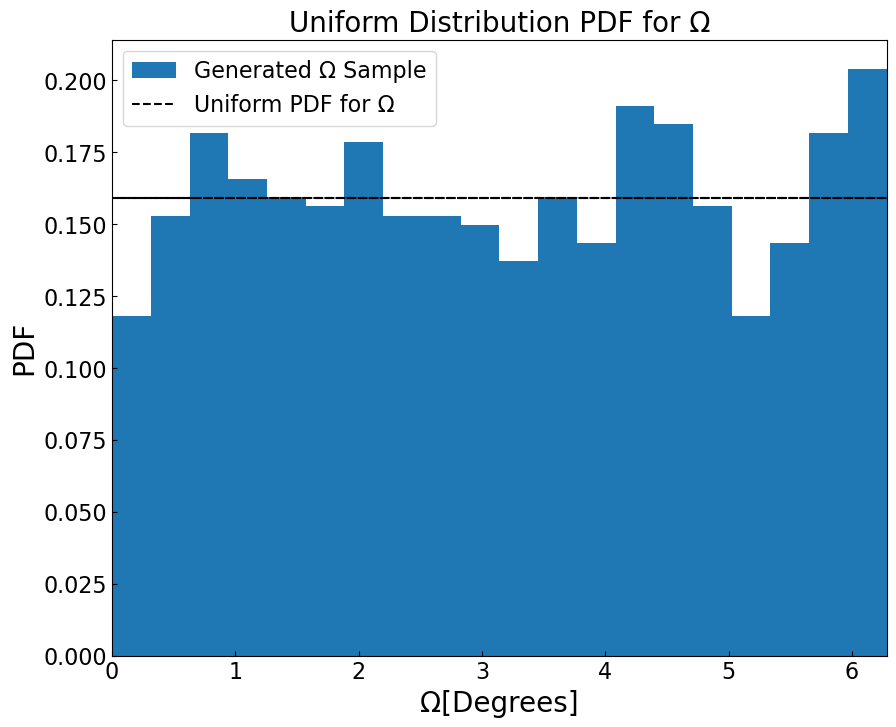

In [22]:
# Allow the Greek letter Ω to be shown in labels, titles and axes
cap_omega = "\u03A9"

# Since Ω is also uniform between 0 and 360, we can use np.random.rand() again
Omega = np.random.uniform(0, 2 * np.pi,1000)

# Create an array of the same shape as Ω where every element is filled with the value
uniform_pdf = np.full_like(Omega, 1/(np.pi * 2))  

# Plot the uniform PDF and generated Ω samples
plt.figure(figsize=(10, 8))
plt.hist(Omega, density = True, label = 'Generated '+ cap_omega +' Sample', bins = 20)
plt.plot(Omega, uniform_pdf, color='black', linestyle = '--', label='Uniform PDF for ' + cap_omega)
plt.xlabel(cap_omega + '[Degrees]', fontsize=20)
plt.ylabel('PDF', fontsize=20)
plt.tick_params(direction='in', labelsize=16)
plt.xlim(0, np.pi * 2)
plt.legend(fontsize=16)
plt.title('Uniform Distribution PDF for ' + cap_omega, fontsize=20)
plt.show()

### Generating 𝜔, longitude of pericentre



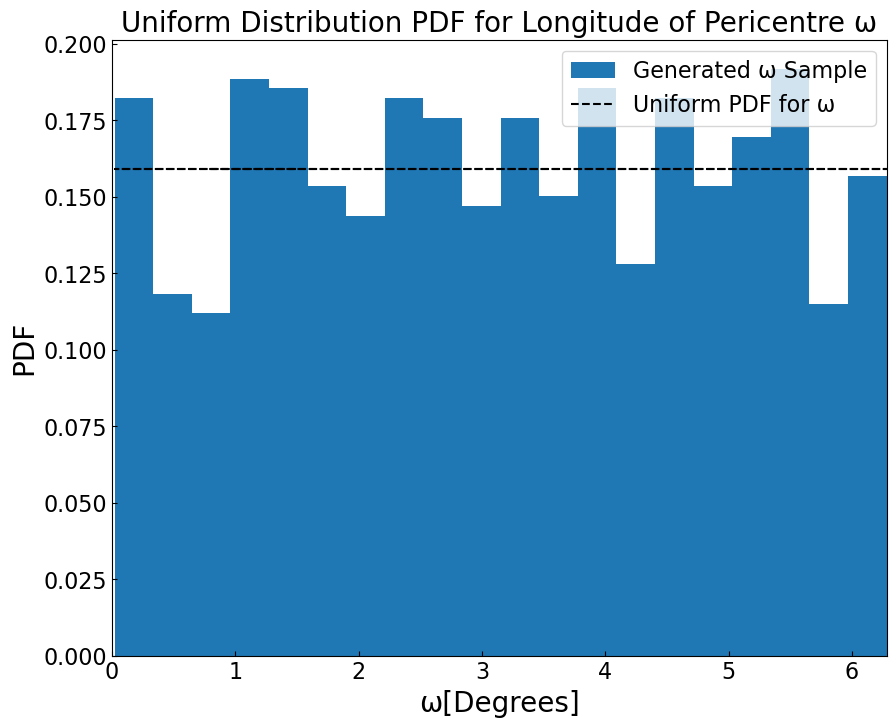

In [24]:
# Allow the Greek letter 𝜔 to be shown in labels, titles and axes
low_omega = "\u03C9"

# Since 𝜔 is uniform between 0 and 360, we can use np.random.rand()
omega = np.random.uniform(0, 2 * np.pi,1000)

# Create an array of the same shape as 𝜔 where every element is filled with the value
uniform_pdf = np.full_like(omega, 1/(2 * np.pi))  

# Plot the uniform PDF and generated 𝜔 samples
plt.figure(figsize=(10, 8))
plt.hist(omega, density = True, label = 'Generated '+ low_omega +' Sample', bins = 20)
plt.plot(omega, uniform_pdf, color='black', linestyle = '--', label='Uniform PDF for ' + low_omega)
plt.xlabel(low_omega + '[Degrees]', fontsize=20)
plt.ylabel('PDF', fontsize=20)
plt.tick_params(direction='in', labelsize=16)
plt.xlim(0, np.pi * 2)
plt.legend(fontsize=16)
plt.title('Uniform Distribution PDF for Longitude of Pericentre ' + low_omega, fontsize=20)
plt.show()

### Generating Inclination \(I\)



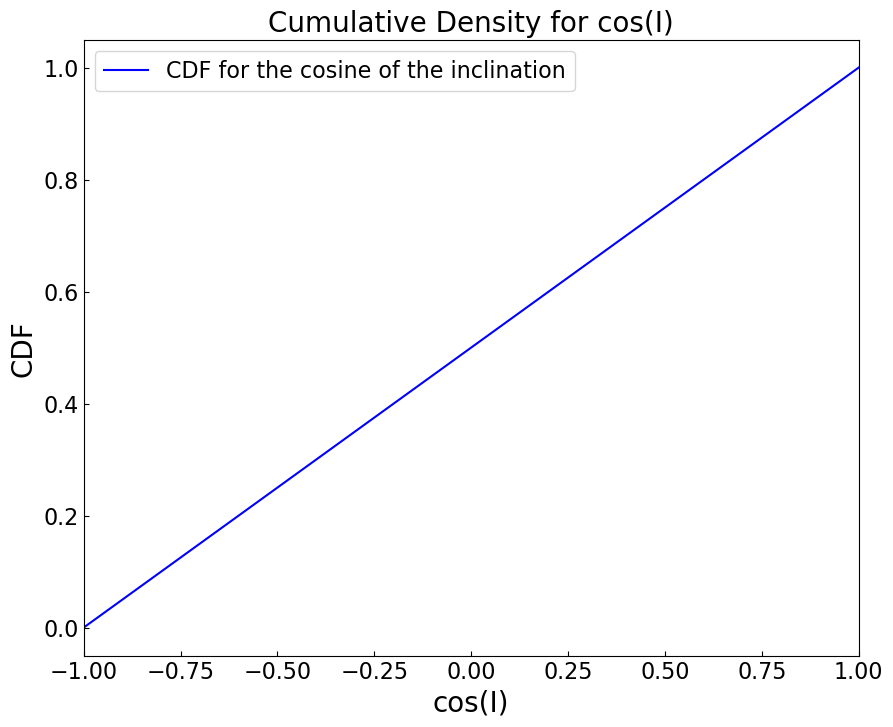

In [27]:
# Generate the x axis for the cosine of the inclination
x_axis_cosI = np.linspace(-1, 1, 1000)

cosI_pdf = np.linspace(1/2,1/2,1000) # Creating our uniform distribution (PDF) for cos(I)
# And creating the CDF based on the PDF, with our function created earlier
cosI_cdf = CDF_generator(cosI_pdf, x_axis_cosI)

# Plotting the uniform CDF
plt.figure(figsize=(10, 8))
plt.plot(x_axis_cosI, cosI_cdf, color='blue', label='CDF for the cosine of the inclination')
plt.xlabel('cos(I)', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.tick_params(direction='in', labelsize=16)
plt.xlim(-1, 1)
plt.legend(fontsize=16)
plt.title('Cumulative Density for cos(I)', fontsize=20)
plt.show()

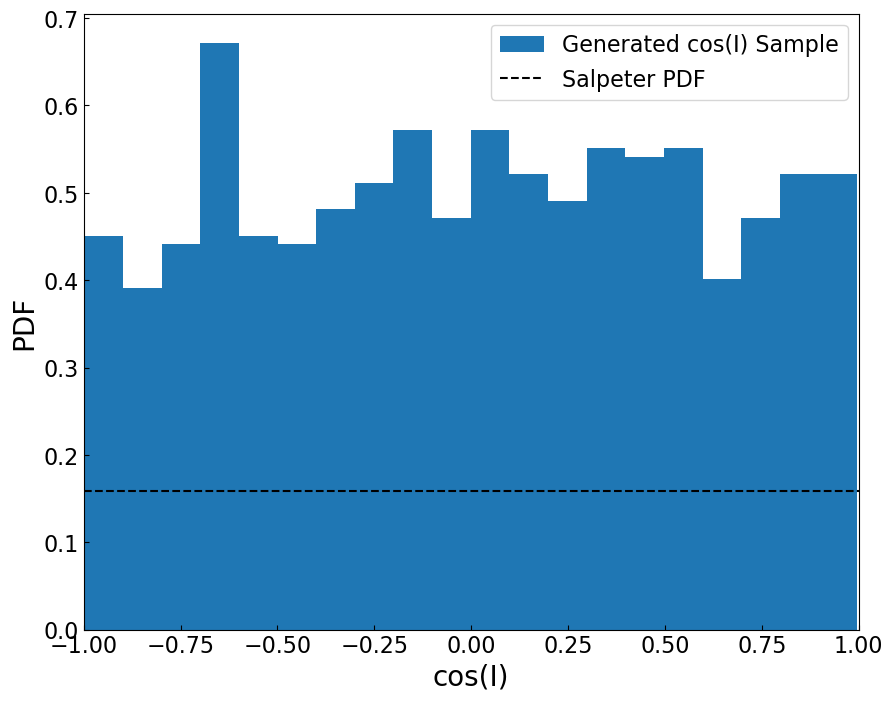

In [28]:

CDFcosI_interp = sci.interpolate.interp1d(x_axis_cosI, cosI_cdf)
sample_cosI = sample_generator(1000, CDFcosI_interp, x_axis_cosI)

plt.figure(figsize = (10, 8))
plt.hist(sample_cosI, density = True, label = 'Generated cos(I) Sample', bins = 20)
plt.plot(x_axis_cosI, uniform_pdf, color = 'black', linestyle = '--', label  = 'Salpeter PDF')
plt.xlabel('cos(I)', fontsize = 20)
plt.ylabel('PDF', fontsize = 20)
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend(fontsize = 16)
plt.xlim(-1, 1)
plt.show()

```

```


$$
x
$$



### Generating eccentricity \(e\)



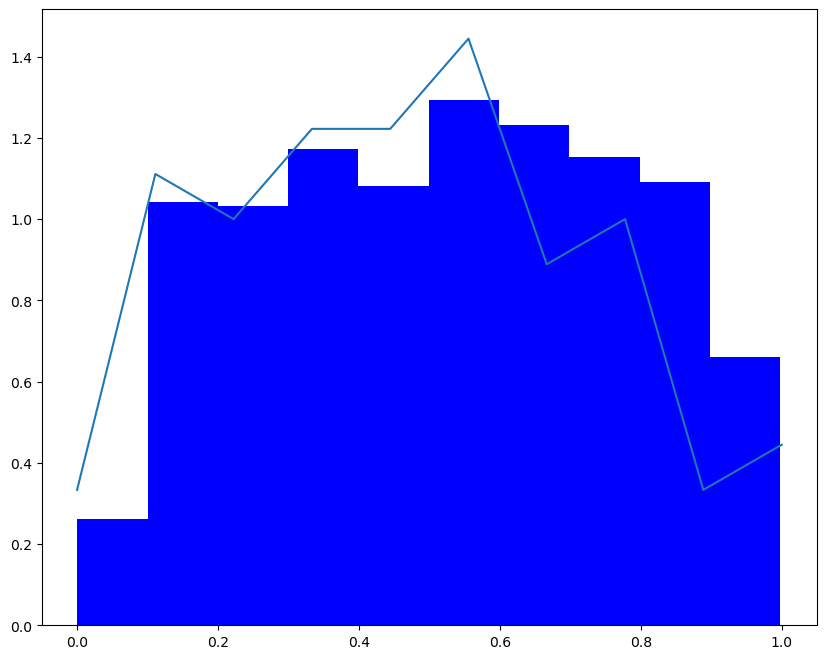

In [31]:
# Getting these values from Raghavan, 2010 (Fig. 15)
ecc_less_1000_days_not_normal = [4/34, 5/34, 5/34, 6/34, 2/34, 7/34, 2/34, 1/34, 1/34, 1/34]
ecc_more_1000_days_not_normal = [3/81, 10/81, 9/81, 11/81, 11/81, 13/81, 8/81, 9/81, 3/81, 4/81]

x_axis_ecc = np.linspace(0, 1, 10)

normal = 1 / (sum(ecc_less_1000_days_not_normal) * (x_axis_ecc[1] - x_axis_ecc[0]))

ecc_less_1000_days = np.array(ecc_less_1000_days_not_normal)*normal
ecc_more_1000_days = np.array(ecc_more_1000_days_not_normal)*normal

cdf_ecc_less_1000_days = CDF_generator(ecc_less_1000_days, x_axis_ecc)
cdf_ecc_less_interp = sci.interpolate.interp1d(x_axis_ecc, cdf_ecc_less_1000_days)

cdf_ecc_more_1000_days = CDF_generator(ecc_more_1000_days, x_axis_ecc)
cdf_ecc_more_interp = sci.interpolate.interp1d(x_axis_ecc, cdf_ecc_more_1000_days)

# Ordered from 0.0 to 1.0
period = 1005 #GET THE PERIOD HERE SOMEHOW!
if period <= 12:
    print("hello")
elif period <= 1000:
    # Create the CDF
    # And interpolate it so we can do the inverse random sampling
    
    sample_ecc = sample_generator(1000, cdf_ecc_less_interp, x_axis_ecc)
    
    plt.figure(figsize=(10, 8))
    plt.hist(sample_ecc, density = True, color='blue', label='CDF for the eccentricity')
    plt.plot(x_axis_ecc, ecc_less_1000_days)
else:
    # Create the CDF
    
    # And interpolate it so we can do the inverse random sampling
    
    sample_ecc = sample_generator(1000, cdf_ecc_more_interp, x_axis_ecc)
    
    plt.figure(figsize=(10, 8))
    plt.hist(sample_ecc, density = True, color='blue', label='CDF for the eccentricity')
    plt.plot(x_axis_ecc, ecc_more_1000_days)
plt.show()

# Radius Generation

Luckily, the radii won't follow a random distribution becuase the radius depends solely on the mass of the star. So if we generate the mass of the star we'll determine the radius of the star. The relation between the mass and the radius follows the form:

$\frac{R}{R_{\odot}} = \frac{M}{M_{\odot}}^{\xi}$ where $\xi = 0.8$ for $M < 1 M_{\odot}$ and $\xi = 0.53$ for $M > 1 M_{\odot}$ 



In [33]:
#Generate a radius for the stars

def radius_generator(M):

    #Check to see if the mass is large
    if M < 1:

        #Use larger exponent
        xi = 0.8

    #if star IS massive
    else:
        #Use the lower exponent
        xi = 0.53

    #Generate the radius in solar radii
    R = M ** xi

    return R
    

## Generate A Random Sample of N Binary Systems

With the above distributions we need to make a set of Binary systems to comprise our population. Of these we will investigate which ones eclipse and eventually check the distributions of their masses, periods, eccentricities, and angular components to check how it stacks up against the initial population.

To make a large sample we'll make one function with one input, N, which dictates how many systems will be generated.  The function will then go through and generate N random values from each distribution for this sample. We want to make something that's fairly efficient but keeps in mind the complex relationships between the parameters at play. For example, the period of the orbits do not depend on the masses or orbital angles of the orbit and so N random periods can be generated at once. This saves time as we only need to build the CDF from the Salpeter PDF one time and just get N numbers we can store for later. However, the eccentricities DO depend on the period of the orbits. This means we'll need to generate our periods first and use that information as a prior to what eccentricities are more likely. We also want to keep the efficient step of only building our CDFs once to reduce computational load.

Another pitfall we want to avoid is with the stellar masses. Although the primary mass can be generated from the Salpeter IMF without issue the secondary mass is not as simple. If we just generate a secondary mass from a uniform distributions of mass ratios from 0.1 to 1 then we may end up generating impossibly small stars around less massive primary stars. To prevent this we need to carefully set the lower bound of the mass ratio, q, to be free to change in case the mass of the primary star is sufficiently low. This is to avoid generating a secondary star with a mass of $0.03 M_{\odot} \leq M_{2} \leq 0.1$ where $M_2$ is the secondary mass.

After all the values are generated we'll have a few independents lists. To brig them all together we simply need to call np.array which will take our lists and paste them together as columns in a 2D array. Each row will represent one system and each column will represent a parameter such as Mass.

In [35]:
#Enter integer
#Return 2D array of binary systems
def pop_genesis(N):

    ##First, generate the Masses and Radii
    #Generate the first mass using the Salpeter IMF
    #Then generate the second mass from the mass ratio
    #use the masses to calculate the radii in solar radii
    #using radius_generator()
    
          
    ##Radii will be necessary for when we need to calculate
    #Projected separation later on
    
    #generate list of masses of primary star in solar masses
    
    M_1 = sample_generator(N, Salpeter_cdf_interp, M)
    
    #initialize lists to hold secondary mass
    #radius of primary star
    #and radius of secondary star
    M_2 = []
    R_1 = []
    R_2 = []

    for mass_1 in M_1:
        
        #set lower bound of mass ratio to prevent undermassive stars
        lower_bound_q = max(0.1/mass_1, 0.1)
        
        #generate random value of q
        q = np.random.uniform(lower_bound_q, 1)
        
        #calculate mass of secondary star in solar mass using mass ratio
        mass_2 = mass_1*q
        
        #add them to the list
        M_2.append(mass_2)
        
        # Also, generate the radii in this same loop in solar radii
        r1 = radius_generator(mass_1)
        r2 = radius_generator(mass_2)
        # And add them to the radii lists
        R_1.append(r1)
        R_2.append(r2)
 
    
    
    ##Third, generate Period and Eccentricity of the orbit
    ##The Period is pulled from a log-normal distribution
    ##which is then used to determine from what distribution
    ##from Raghavan we'll used
    
    #Generate list of periods in days in log space
    log_P_sample = sample_generator(N, log_P_cdf_interp, log_P)
    
    Ecc = []
    #Generate eccentricity based on the period of the binary
    for log_p in log_P_sample:
        # Calculate the period based on log_p
        period = 10**log_p
        # Now, check: if the period is really small, the eccentricity should be
        # a random value between 0 and 0.05
        if period <= 12:
            e = np.random.uniform(0, 0.05)
        # If its between 12 and 1000, it should follow the CDF calculated before
        elif period <= 1000:
            e = sample_generator(1, cdf_ecc_less_interp, x_axis_ecc)[0]
        # And if its more than 1000, do the same as we found beforehand
        else:
            e = sample_generator(1, cdf_ecc_more_interp, x_axis_ecc)[0]
        Ecc.append(e)
        

    
    
    ##Fourth, generate all the angular components, Ω, ω, cos(i)
    ##of all the orbits

    Omega = np.random.uniform(0, 2 * np.pi, N) #Ω
    omega = np.random.uniform(0, 2 * np.pi, N) #ω
    cos_i = np.random.uniform(-1, 1, N) #cos(i)
    
    
    ##Finally, take all these lists and paste them together into one
    ##Array
    
    binary_population = np.column_stack((M_1, M_2, R_1, R_2, log_P_sample, Ecc, Omega, omega, cos_i))
    
    return binary_population

population = pop_genesis(1000)

In [36]:
population[0]

array([ 0.11434822,  0.10350457,  0.17643451,  0.16291746,  6.49605225,
        0.3760376 ,  3.79075305,  0.8538583 , -0.29484641])

In [37]:
# distance as a function of theta (not the actual thing i just wanted to see how I can calculate it)
num_steps = 1000
theta = np.linspace(0,2*np.pi,num_steps)

# calculate semi-major axis (a) in metres as a function of M_1 and P
def semimajoraxis(M_1, log_P_sample):
    # convert log_P back to P first, and subsequently convert to years for Kepler's Third Law calculations
    P = (10**log_P_sample) / 365.25
    # apply kepler's third law to find the semi-major axis in terms of M_1 and P: (P^2 = (4п^2 / (G * M_1)) * a^3), so
    # first define Gravitational Constant G
    G = 6.674*10**-11
    # a should be in meters, but Kepler's Third Law uses AU, so we have to convert it back
    a = (np.cbrt((P**2*G*M_1*2*10**30)/(4*(np.pi)**2)))/
    return a
print(a)

# using the data from population[0]
a = semimajoraxis(population[0][0], population[0][4])
Ecc = population[0][5]
Omega = population[0][6]
omega = population[0][7]
cos_i = population[0][8]
  
# copy and pasted from David so maybe fix te wording a bit
def calc_pos(theta, a, Ecc, omega, Omega, cos_i):
    # the line below is Kepler's 1st law because it shows that the relative distance between the centres of each star, r, follows an ellipse
    r = a*(1-Ecc**2.)/(1+Ecc*np.cos(theta-omega)) # the relative distance between the centres of each star
    # Calculate the 3d positions as a function of theta
    x = r*(np.cos(Omega)*np.cos(theta) - np.sin(Omega)*np.sin(theta) * (cos_i))
    y = r*(np.sin(Omega)*np.cos(theta) + np.cos(Omega)*np.sin(theta) * (cos_i))
    z = r*np.sin(theta)*(1-(cos_i)**2)**0.5
    return [x,y,z]
positions = calc_pos(theta,a,Ecc,omega,Omega,cos_i)

x = positions[0] # x over the orbit
y = positions[1] # y over the orbit
z = positions[2] # z over the orbit

# projected separation
s = (y**2+z**2)**0.5

# convert star radii from solar radii to meters
R_1 = population[0][2] * 6.957e8
R_2 = population[0][3] * 6.957e8
    
# Plot the scaled projected separation
plt.scatter(np.degrees(theta),s/(R_1+R_2),c = theta,s=2)
plt.axhline(y=1 , color='black', linestyle='--')
plt.xlabel('theta (deg)',fontsize=18)
plt.ylabel('s (scaled projected separation)',fontsize=18)
plt.xticks([0,45,90,135,180,225,270,315,360])
plt.xlim([0,360])
plt.show()
print(s[0]/(R_1+R_2))

SyntaxError: invalid syntax (3046025297.py, line 13)